# Introduction

**Problem:** Use a pretrained ResNet 18 and train on the Imagewoof dataset. Use mixmatch and discriminative learning rates. Measure its effect on your model's performance.

**Dataset:** Imagewoof is a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds. The breeds are: Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog. 

The Imagewoof is a noisy dataset. In this challenge, we will remove the noisy labels and perform training using different models, then compare their accuracies. As a benchmark, we will use transfer learning and perform feature extraction from a pre-trained ResNet18 model, and then train a final classifier layer to get the best accuracy that can be achieved. Firstly, we will compare its performance with a fine-tuned ResNet18 model using discriminative learning rates. Secondly, we will compare its performance to a model using MixMatch, a semi-supervised learning algorithm.

The dataset is split into 70/30 train/val sets. Usually, in addition to validation set (used to hyperparameters tuning), there will also be a test set in order to estimate the model performance. However, in this case we decided to use the same set for both validation and testing. The justification is that we are not expecting any significant hyperparameters tuning, especially since we are using transfer learning.

# Data preprocessing

In [ ]:
import pandas as pd
import os
import shutil
import tarfile
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url

Download the Imagewoof dataset.

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz"
download_url(dataset_url, '.')

# Extract the archive
with tarfile.open('./imagewoof2-320.tgz', 'r:gz') as tar:
    # Extract all folders from zip file and store under folder named data
    if os.path.isdir('./data'):
        shutil.rmtree('./data')
    tar.extractall(path = './data')

Using downloaded and verified file: ./imagewoof2-320.tgz


## Generate unlabelled data

The dataset contains 2 folders named train and val. Each of them contains 10 folders, one for each class of images.

In [ ]:
source_dir = './data/imagewoof2-320'
print("Dataset contains 2 folders: ", os.listdir(source_dir))
print("Each containing 10 folders for the 10 classes: ", 
      os.listdir(os.path.join(source_dir, 'train')))

Dataset contains 2 folders:  ['train', 'noisy_imagewoof.csv', 'val']
Each containing 10 folders for the 10 classes:  ['n02099601', 'n02086240', 'n02093754', 'n02096294', 'n02087394', 'n02105641', 'n02088364', 'n02115641', 'n02089973', 'n02111889']


Since classes are not in the name of the folder, create an array for the name of the breeds as mentioned on its original link/website (https://github.com/fastai/imagenette).

In [ ]:
classes = ['Australian terrier', 'Border terrier', 'Samoyed', 'Beagle', 
           'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 'Dingo', 
           'Golden retriever', 'Old English sheepdog']

The Imagewoof dataset also comes with a CSV file with 0%, 1%, 5%, 25%, and 50% of the labels randomly changed to an incorrect label. Since the challenge does not specify the exact % as a split point, we decided to remove 50% of the noisy labels based on the supplied "noisy_imagewoof.csv". In effect, we are treating 50% of the train images as unlabelled.

Note that we decided to remove the noisy data even for the benchmark model (i.e. pre-trained ResNet18). This is because we believe training it on the noisy data will not make a fair comparison since we already know for a fact that data is noisy.

In order to achieve this, we will move all images which have their labels randomly changed (according to the supplied CSV) into a separate folder representing the unlabelled class. In other words, all images which have their labels changed in the supplied CSV will be treated as unlabelled in this semi-supervised learning problem.

Firstly, we shall load the supplied CSV file with information on noisy labels. In this case, we are interested in the "noisy_labels_0" column (true labels) and "noisy_labels_50" column (50% of the labels are noisy).

In [ ]:
df_labels = pd.read_csv(os.path.join(source_dir, 'noisy_imagewoof.csv'))
df_labels.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02115641/n02115641_3995.JPEG,n02115641,n02115641,n02115641,n02115641,n02115641,False
1,train/n02115641/n02115641_843.JPEG,n02115641,n02115641,n02105641,n02115641,n02088364,False
2,train/n02115641/n02115641_2953.JPEG,n02115641,n02115641,n02115641,n02111889,n02099601,False
3,train/n02115641/n02115641_6458.JPEG,n02115641,n02115641,n02115641,n02093754,n02115641,False
4,train/n02115641/n02115641_19414.JPEG,n02115641,n02115641,n02115641,n02115641,n02088364,False


Next, we will create a new directory called "modified" that will hold the correctly and incorrectly labelled images.

In [ ]:
data_dir = './data/modified'

for dirpath, _, _ in os.walk(source_dir):
    structure = os.path.join(data_dir, dirpath[len(source_dir)+1:])
    if not os.path.isdir(structure):
        os.mkdir(structure)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
unlabelled_dir = os.path.join(data_dir, 'unlabelled')

if not os.path.isdir(unlabelled_dir):
    os.mkdir(unlabelled_dir)

We will now populate the newly created directory with images from "imagewoof2-320" directory according to their classes and whether they are labelled/unlabelled.

In [ ]:
def move_file(row):
    true_label = row['noisy_labels_0'].strip()
    noisy_label = row['noisy_labels_50'].strip()
    path = row['path'].split('/')
    if true_label == noisy_label:
        # For labelled images
        shutil.move(os.path.join(source_dir, *path), 
                    os.path.join(data_dir, *path))
    else:
        # For unlabelled images
        shutil.move(os.path.join(source_dir, *path), 
                    os.path.join(data_dir, 'unlabelled', path[2]))

df_labels.apply(move_file, axis=1);

It can be seen that the number of labelled and unlabelled train images are roughly equal, meaning that the original train data has been split into 50% labelled and 50% unlabelled.

In [ ]:
total_train = 0
for folder in os.listdir(train_dir):
    total_train += len(os.listdir(os.path.join(train_dir, folder)))
total_unlabelled = len(os.listdir(unlabelled_dir))
print(f"no. of labelled train: {total_train}")
print(f"no. of unlabelled train: {total_unlabelled}")

no. of labelled train: 4512
no. of unlabelled train: 4513


## Load image datasets

### Image preprocessing

In [ ]:
# Transform all the images into tensors
image_size_test = ImageFolder(train_dir, tt.ToTensor())

In [ ]:
# Check the size of the first 10 images in the dataset
for i in range(10):
    image, _ = image_size_test[i]
    print(image.shape)

torch.Size([3, 320, 426])
torch.Size([3, 320, 426])
torch.Size([3, 375, 320])
torch.Size([3, 320, 426])
torch.Size([3, 320, 426])
torch.Size([3, 320, 426])
torch.Size([3, 320, 426])
torch.Size([3, 320, 426])
torch.Size([3, 320, 426])
torch.Size([3, 320, 426])


We can see that images have different sizes. Now find out the minimum height and width of the images.

In [ ]:
height = []
width = []
for image,_ in image_size_test:
    height.append(image.shape[1])
    width.append(image.shape[2])
print(f"minimum height: {min(height)}, maximum height: {max(height)}")
print(f"minimum width: {min(width)}, maximum width: {max(width)}")

minimum height: 320, maximum height: 783
minimum width: 320, maximum width: 747


Since the images have minimum width and height of 320 pixels, we shall resize them all to (320 x 320) to avoid getting errors due to size difference. 

In order to do this, create image transformers for both the train and val sets, then transform the images. Note that the normalization stats are specific to the ImageNet data.

In [ ]:
image_tfms = tt.Compose([tt.RandomCrop(320), 
                         tt.ToTensor(),
                         tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

Automatically load the images and their labels based on the directory structure (i.e. images in the same class are arranged in the same folder) using the `ImageFolder` data loader.


In [ ]:
train_ds = ImageFolder(train_dir, image_tfms)
val_ds = ImageFolder(val_dir, image_tfms)

Now check the minimum height and width of the train images after the transformation.

In [ ]:
height = []
width = []
for image,_ in train_ds:
    height.append(image.shape[1])
    width.append(image.shape[2])
print(f"minimum height: {min(height)}, maximum height: {max(height)}")
print(f"minimum width: {min(width)}, maximum width: {max(width)}")

minimum height: 320, maximum height: 320
minimum width: 320, maximum width: 320


Now all the images in the dataset have the same size of 320 x 320.

Next, we create a dictionary by matching the classes (which are in numbers) of the dataset and it's names in text.

In [ ]:
classes_dict = dict(zip(train_ds.classes, classes))
print(classes_dict)

{'n02086240': 'Australian terrier', 'n02087394': 'Border terrier', 'n02088364': 'Samoyed', 'n02089973': 'Beagle', 'n02093754': 'Shih-Tzu', 'n02096294': 'English foxhound', 'n02099601': 'Rhodesian ridgeback', 'n02105641': 'Dingo', 'n02111889': 'Golden retriever', 'n02115641': 'Old English sheepdog'}


### Visualize images

Visualize some images to grasp the nature of the data.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img,label):
    print('Label: ', classes[label], '('+str(label)+')')
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Australian terrier (0)


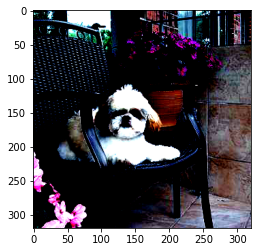

In [ ]:
# First image in the train set
show_example(*train_ds[0])

Label:  Australian terrier (0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


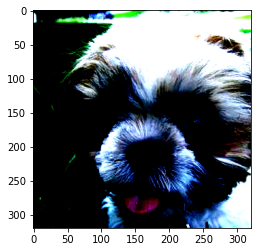

In [ ]:
# First image in the test set
show_example(*val_ds[0])

### Generate dataset for unlabelled images

Unlike the training images (labelled), the unlabelled images are not split into subfolders. Thus, `ImageFolder` will not work.

To circumvent, we will define a custom dataset class that inherits from the `Dataset` class.

In [ ]:
from torch.utils.data import Dataset
from natsort import natsorted

class UnlabelledDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

Then use it to construct the unlabelled dataset.

In [ ]:
unlabelled_ds = UnlabelledDataSet(unlabelled_dir, transform=image_tfms)

# Pre-trained ResNet18 model

In this section, we will use a pre-trained ResNet18, which is an 18-layers residual neural network pretrained on the ImageNet 2012 classification dataset consisting of 1000 classes. More details on ResNet can be found in the original paper by He et al. (2016): https://arxiv.org/pdf/1512.03385.pdf

It is possible to fine-tune all the layers of the ResNet18, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset.

In this section, we will treat the pre-trained ResNet18 as a fixed feature extractor. We will remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ResNet18 as a fixed feature extractor for the Imagewoof dataset. Recall that the Imagewoof has 10 classes, so the new last fully-connected layer should output 10 classes.

In [ ]:
import numpy as np
import json
import time
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data.dataloader import DataLoader
from PIL import Image

# # Set random seed for reproducability
# random_seed = 4078708226662187785 10013937438585891429 10884579821992081530
# torch.manual_seed(random_seed);

## Create dataloaders for training and validation images

Create dataloaders so that data can be loaded by the batches for SGD.

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers= 8, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=8, pin_memory=True)

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Load and train the pre-trained ResNet18 model

In [ ]:
# Load pre-trained ResNet18 and replace the last fully-connected layer
model_fe = models.resnet18(pretrained=True)
num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, len(classes))

model_fe = model_fe.to(device)

criterion = nn.CrossEntropyLoss()

# Note that only parameters of the final layer are being optimized
optimizer_fe = optim.SGD(model_fe.fc.parameters(), lr=1e-2, momentum=0.9)

We will define two helper functions: `accuracy` and `evaluate` for evaluating model performance on the validation set.

In [ ]:
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, criterion, val_loader):
    model.eval()
    loss, acc = [], []
    for images, labels in val_loader:
        preds = model(images)
        loss.append(criterion(preds, labels).detach())
        acc.append(accuracy(preds, labels))
    return {'val_loss': torch.stack(loss).mean().item(), 
            'val_acc': torch.stack(acc).mean().item()}

Define the `fit` function to train the model using gradient descent.

In [ ]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    history = []
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_acc = []

        for images, labels in train_loader:
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            train_losses.append(loss)
            train_acc.append(accuracy(preds, labels))
            loss.backward()
            optimizer.step()

        # Validation phase
        result = evaluate(model, criterion, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        history.append(result)
    return history

Train the model.

In [ ]:
num_epochs = 20

history_fe = fit(num_epochs, model_fe, train_dl, val_dl, criterion, optimizer_fe)

Epoch [0], train_loss: 0.6431, train_acc: 0.8085, val_loss: 0.2734, val_acc: 0.9213
Epoch [1], train_loss: 0.2488, train_acc: 0.9232, val_loss: 0.2434, val_acc: 0.9261
Epoch [2], train_loss: 0.2074, train_acc: 0.9357, val_loss: 0.2505, val_acc: 0.9212
Epoch [3], train_loss: 0.1948, train_acc: 0.9426, val_loss: 0.2207, val_acc: 0.9333
Epoch [4], train_loss: 0.1743, train_acc: 0.9476, val_loss: 0.2424, val_acc: 0.9227
Epoch [5], train_loss: 0.1597, train_acc: 0.9520, val_loss: 0.2122, val_acc: 0.9352
Epoch [6], train_loss: 0.1633, train_acc: 0.9503, val_loss: 0.2271, val_acc: 0.9302
Epoch [7], train_loss: 0.1420, train_acc: 0.9573, val_loss: 0.2215, val_acc: 0.9339
Epoch [8], train_loss: 0.1509, train_acc: 0.9547, val_loss: 0.2193, val_acc: 0.9295
Epoch [9], train_loss: 0.1376, train_acc: 0.9542, val_loss: 0.2165, val_acc: 0.9302
Epoch [10], train_loss: 0.1311, train_acc: 0.9613, val_loss: 0.2216, val_acc: 0.9332
Epoch [11], train_loss: 0.1290, train_acc: 0.9604, val_loss: 0.2144, val_ac

Plot the accuracies.

In [ ]:
def plot_accuracies(history):
  train_acc = [x.get('train_acc') for x in history]
  val_acc = [x['val_acc'] for x in history]
  plt.plot(train_acc, '-bx')
  plt.plot(val_acc, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['Training','Validation'])
  plt.title('Accuracy vs No. of epoch')

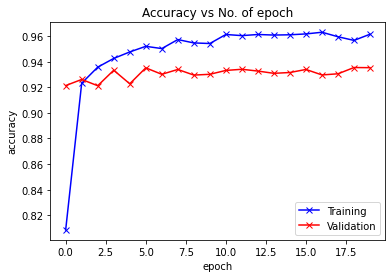

In [ ]:
plot_accuracies(history_fe)

It can be seen that the validation accuracy stabilized around ~93%, whereas the train accuracy is at ~95.5%.

# Discriminative learning rates

In this section, we will fine-tune the weights of the pretrained network (i.e. ResNet18) by continuing the backpropagation. We will apply **discriminative learning rates** in which the earlier layers shall have very small learning rates (because we expect that the ConvNet weights are relatively good, so we don’t wish to distort them too quickly and too much) and later layers have progressively higher learning rates, due to the previously described reasoning.

## Load the pre-trained ResNet18 model

Reload original pre-trained ResNet18 (without any further training from the previous section). However, this time we will finetune the first four layers along with the final layer. The 1st and 2nd layers shall have a learning rate of 0.00001, the 3rd and 4th layers shall have a learning rate of 0.001, and the final layer shall have a learning rate of 0.01.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Note that discriminative learning rates are being applied
optimizer_ft = optim.SGD([{'params': model_ft.layer1.parameters()},
                          {'params': model_ft.layer2.parameters()},
                          {'params': model_ft.layer3.parameters(), 'lr': 1e-3},
                          {'params': model_ft.layer4.parameters(), 'lr': 1e-3},
                          {'params': model_ft.fc.parameters(), 'lr': 1e-2}], 
                         lr=1e-5, momentum=0.9)

## Finetune the ResNet 18 model

In [ ]:
num_epochs = 20

history_ft = fit(num_epochs, model_ft, train_dl, val_dl, criterion, optimizer_ft)

Epoch [0], train_loss: 0.6002, train_acc: 0.8217, val_loss: 0.2532, val_acc: 0.9218
Epoch [1], train_loss: 0.1953, train_acc: 0.9439, val_loss: 0.2189, val_acc: 0.9308
Epoch [2], train_loss: 0.1416, train_acc: 0.9593, val_loss: 0.2103, val_acc: 0.9352
Epoch [3], train_loss: 0.1161, train_acc: 0.9685, val_loss: 0.2112, val_acc: 0.9302
Epoch [4], train_loss: 0.0921, train_acc: 0.9749, val_loss: 0.2062, val_acc: 0.9352
Epoch [5], train_loss: 0.0836, train_acc: 0.9776, val_loss: 0.2084, val_acc: 0.9312
Epoch [6], train_loss: 0.0626, train_acc: 0.9842, val_loss: 0.2167, val_acc: 0.9309
Epoch [7], train_loss: 0.0524, train_acc: 0.9861, val_loss: 0.2076, val_acc: 0.9338
Epoch [8], train_loss: 0.0483, train_acc: 0.9901, val_loss: 0.2107, val_acc: 0.9332
Epoch [9], train_loss: 0.0376, train_acc: 0.9947, val_loss: 0.2106, val_acc: 0.9349
Epoch [10], train_loss: 0.0333, train_acc: 0.9943, val_loss: 0.2198, val_acc: 0.9344
Epoch [11], train_loss: 0.0265, train_acc: 0.9971, val_loss: 0.2180, val_ac

Plot the accuracies.

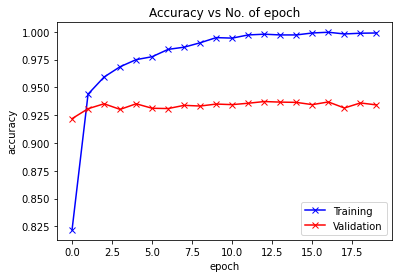

In [ ]:
plot_accuracies(history_ft)

It can be seen that the validation accuracy stabilized at around ~93.5%, whereas the train accuracy is at ~99%. Compared to just training the last fully-connected layer (feature extraction), an improvement of around 0.5% was achieved on the validation set through finetuning.

# MixMatch

Our model so far only used 50% of the available "train data" because only 50% are labelled, while the rest are unlabelled and cannot be used for further training.

In this section, we shall implement MixMatch, a semi-supervised learning (SSL) method which combines ideas and components from the current dominant paradigms for SSL. It is based on the following paper: https://paperswithcode.com/paper/mixmatch-a-holistic-approach-to-semi

## Define helper functions

We shall first create helper functions which will be used by the MixMatch algorithm.

MixMatch introduced several hyperparameters. In regard to this, the paper suggested:

> We find in practice that most of MixMatch’s hyperparameters can be fixed and do not need to be tuned on a per-experiment or per-dataset basis. Specifically, for all experiments we set $T=0.5$ and $K=2$. Further, we only change $\alpha$ and $\lambda_U$ on a per-dataset basis; we found that $\alpha=0.75$ and $\lambda_U=100$ are good starting points for tuning.

As such, we will adopt the recommended hyperparameters listed in the paper.

Firstly, we define a function to get the augmented version of a given batch of images.

In [ ]:
def get_augmenter():
    img_transforms = tt.Compose([tt.RandomCrop(320, padding=32, padding_mode='reflect'), 
                                 tt.RandomHorizontalFlip(),
                                 tt.GaussianBlur(1)])
    def augment(images):
        return img_transforms(images)
    return augment

Next, we define the sharpening function to sharpen the prediction from the averaged prediction of all the unlabeled augmented images. It does the same thing as applying a temperature within the softmax function but to the probabilities.

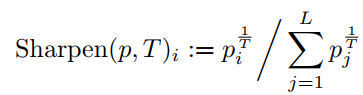

In [ ]:
def sharpen(p, T):
    temp = p.pow(1/T)
    return temp / temp.sum(dim=1, keepdim=True)

Define a function to implement MixUp.

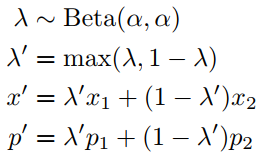

In [ ]:
def mixup(x1, x2, y1, y2, alpha):
    beta = np.random.beta(alpha, alpha)
    beta = max(beta, 1 - beta)
    x = beta * x1 + (1 - beta) * x2
    y = beta * y1 + (1 - beta) * y2
    return x, y

The MixMatch algorithm as covered in the paper is also implemented.




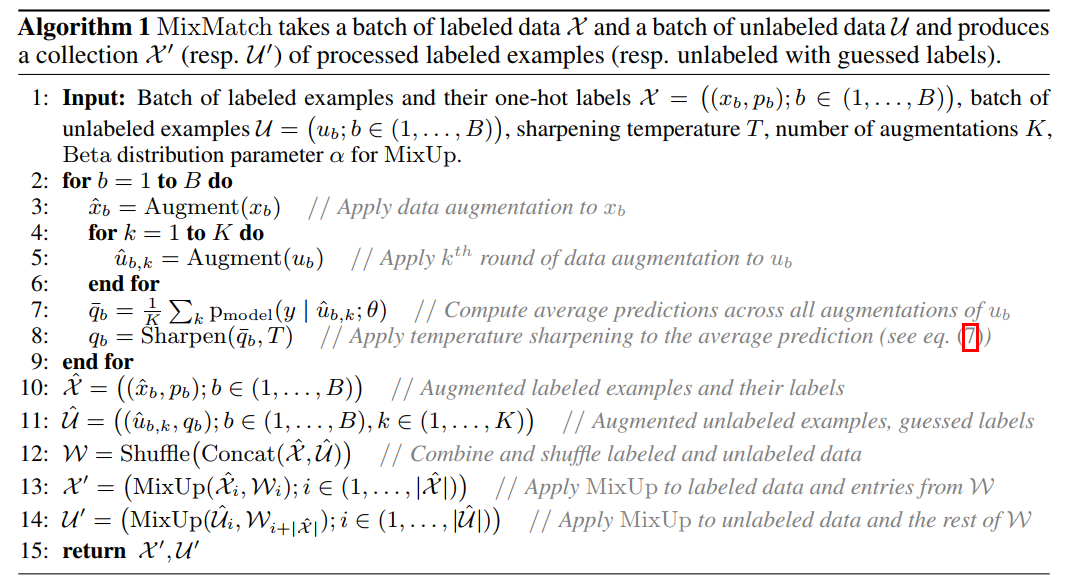

In [ ]:
def mixmatch(x, y, u, model, augment_fn, T=0.5, K=2, alpha=0.75):
    # Apply data augmentation to x
    xb = augment_fn(x) # Shape: 64, 3, 320, 320

    # Convert y to one-hot encoding
    y = torch.nn.functional.one_hot(y, num_classes=len(classes)) # Shape: 64, 10

    # Apply k-th round of data augmentation to u
    ub = [augment_fn(u) for _ in range(K)] # Shape: 2, 64, 3, 320, 320

    # Compute average prediction across all augmentations of u_b and apply sharpening
    with torch.no_grad():
        qb = [torch.softmax(model(ub[i]), dim=1) for i in range(K)] # Shape: 2, 64, 10
        qb = torch.softmax(sharpen(sum(qb) / K, T), dim=1).detach() # Shape: 64, 10

    # Augmented unlabelled examples and their labels
    Ux = torch.cat(ub, dim=0) # Shape: 128, 3, 320, 320
    Uy = torch.cat([qb for _ in range(K)], dim=0) # Shape: 128, 10

    indices = torch.randperm(xb.shape[0] + Ux.shape[0])

    # Combine and shuffle labelled and unlabelled data
    Wx = torch.cat([Ux, xb], dim=0)[indices] # Shape: 192, 3, 320, 320
    Wy = torch.cat([Uy, y], dim=0)[indices] # Shape: 192, 10
    
    # Apply MixUp to labelled data and entries from W
    X, p = mixup(xb, Wx[:len(xb)], y, Wy[:len(xb)], alpha)

    # Apply MixUp to unlabelled data and the rest of W
    U, q = mixup(Ux, Wx[len(xb):], Uy, Wy[len(xb):], alpha)

    return X, U, p, q

Now we define a loss function for MixMatch to compute  the forward propagation losses (labelled and unlabelled losses) as described in the paper. 
- For labelled data, the loss function is the typical cross-entropy loss between labels and model predictions.
- For unlabelled data, the loss function is $L_2$ loss function between guessed labels and model predictions. For this reason, we use Mean Squared Error (MSE) as the loss function in our implementation.

In [ ]:
class MixMatchLoss:
    def __call__(self, preds, p, q, lambda_u=100):
        Lx = -torch.mean(torch.sum(torch.nn.functional.log_softmax(preds[:len(p)], dim=1) * p, dim=1))
        probs = torch.softmax(preds[len(p):], dim=1)
        Lu = torch.mean((probs - q)**2)

        return Lx + lambda_u * Lu

Create a generator that will perform MixMatch on every batches of labelled and unlabelled data and then yield the batch-wise result.

In [ ]:
def mixmatch_gen(train, train_u, model):
    augment_fn = get_augmenter()
    train = iter(train)
    train_u = iter(train_u)
    for (xi, yi), ui in zip(train, train_u):
        yield mixmatch(xi, yi, ui, model, augment_fn)

## Load data and ResNet34 model

Reload the train (labelled), unlabelled, and validation datasets. Additionally, load an untrained ResNet34 (randomly initialized parameters).

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers= 8, pin_memory=True)
train_u_dl = DataLoader(unlabelled_ds , batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=8, pin_memory=True)

# Move datasets into the GPU if available
train_dl = DeviceDataLoader(train_dl, device)
train_u_dl = DeviceDataLoader(train_u_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Initialize a ResNet-34 model without pre-training
model_mm = models.resnet34(pretrained=False)
num_ftrs = model_mm.fc.in_features
model_mm.fc = nn.Linear(num_ftrs, len(classes))

model_mm = model_mm.to(device)

criterion_mm = MixMatchLoss()

# Note that discriminative learning rates are applied
optimizer_mm = optim.Adam(model_mm.parameters(), lr=6e-3)

## Train the MixMatch model

As before, we will define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. 

In [ ]:
def accuracy_mixmatch(preds, labels):
    preds = torch.argmax(preds, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate_mixmatch(model, val_loader):
    model.eval()
    acc = []
    for images, labels in val_loader:
        preds = model(images)
        acc.append(accuracy_mixmatch(preds, labels))
    return {'val_acc': torch.stack(acc).mean().item()}

def fit_mixmatch(epochs, model, train_loader, train_u_loader, val_loader, criterion, optimizer):
    history = []

    for epoch in range(epochs):
        # Training Phase
        model.train() 
        train_losses = []
        train_acc = []

        for X, U, p, q in mixmatch_gen(train_loader, train_u_loader, model):
            with torch.set_grad_enabled(True):
                optimizer.zero_grad()
                X_ = torch.cat([X, U], dim=0)
                preds = model(X_)
                loss = criterion(preds, p, q)
                loss.backward()
                optimizer.step()

            train_losses.append(loss)
            labels = torch.argmax(torch.cat([p, q], dim=0), dim=1)
            train_acc.append(accuracy_mixmatch(preds, labels))

        # Validation phase
        result = evaluate_mixmatch(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_acc']))
        history.append(result)
    
    return history

Train the MixMatch model.

In [ ]:
num_epochs = 100

history_mm = fit_mixmatch(num_epochs, model_mm, train_dl, train_u_dl, val_dl, criterion_mm, optimizer_mm)

Epoch [0], train_loss: 2.9685, train_acc: 0.4123, val_acc: 0.1428
Epoch [1], train_loss: 2.4578, train_acc: 0.4060, val_acc: 0.1700
Epoch [2], train_loss: 2.5046, train_acc: 0.4089, val_acc: 0.1841
Epoch [3], train_loss: 2.4900, train_acc: 0.4113, val_acc: 0.1823
Epoch [4], train_loss: 2.5025, train_acc: 0.3916, val_acc: 0.1636
Epoch [5], train_loss: 2.4399, train_acc: 0.4212, val_acc: 0.2056
Epoch [6], train_loss: 2.4823, train_acc: 0.4351, val_acc: 0.2036
Epoch [7], train_loss: 2.4910, train_acc: 0.4080, val_acc: 0.2040
Epoch [8], train_loss: 2.4738, train_acc: 0.4390, val_acc: 0.2289
Epoch [9], train_loss: 2.4585, train_acc: 0.4268, val_acc: 0.2324
Epoch [10], train_loss: 2.4613, train_acc: 0.4253, val_acc: 0.2303
Epoch [11], train_loss: 2.4293, train_acc: 0.4321, val_acc: 0.2385
Epoch [12], train_loss: 2.4254, train_acc: 0.4313, val_acc: 0.2333
Epoch [13], train_loss: 2.4523, train_acc: 0.4302, val_acc: 0.2402
Epoch [14], train_loss: 2.4373, train_acc: 0.4288, val_acc: 0.2668
Epoch

Plot the accuracies.

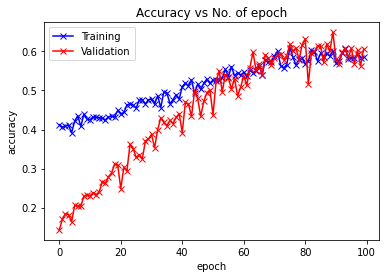

In [ ]:
plot_accuracies(history_mm)

It can be seen that the validation accuracy and train accuracy converged at around ~60%.

We also trained a separate ResNet34 model (uninitialized parameters) on just the labelled images without MixMatch and found that the model with MixMatch performed consistently better than without.

# Conclusions

In this challenge, we investigated transfer learning and MixMatch, a semi-supervised learning algorithm, using PyTorch. The dataset we use is the noisy Imagewoof data with 10 classes, which is split into 70/30 train and validation sets, respectively. Among the train set, 50% is considered as labelled and the other 50% is considered as unlabelled, by following the CSV file provided in the Imagewoof dataset. Notably, we used the same set for validation and testing since we did not expect to perform significant hyperparameters tuning.

For the benchmark, we loaded a pre-trained ResNet18 model and performed feature extraction by replacing only the last fully-connected layer while freezing the rest of model parameters. We trained this model on just the labelled portion of the train set and evaluated its accuracy performance on the validation set. The training converged very fast as expected of a transfer learning model. Within just 10 epochs, the benchmark model already achieved an accuracy of ~93% on the validation set.

Next, we investigated the use of discriminative learning rates in transfer learning. We loaded a new instance of pre-trained ResNet18 model. However, this time we will be performing finetuning. Meaning that we will also be updating the parameters of the intermediate hidden layers during backpropagation. Notably, we set the learning rates of earlier layers to be smaller (i.e. parameters would update at slower rate) and gradually increased the learning rates on later layers. This took advantage of the fact that earlier layers in CNN are mainly responsible for capturing generic features, whereas the later layers would capture more dataset-specific features. In general, we achieved a slightly better performance, with an accuracy of ~93.5% on the validation set.

Finally, we investigated MixMatch, a semi-supervised learning algorithm, which allows for making use of the unlabelled images during training. Firstly, the labelled and unlabelled images were both augmented. The model is then used to predict given the augmented, unlabelled images and then the outputs are temperature sharpened to minimize entropy. MixUp are then applied on the augmented images for regularization. The ResNet34 model without pre-training was then trained using different loss functions, with cross-entropy for labelled images and mean squared error for unlabelled images. The Adam optimizer is used with a fixed learning rate of 0.002. After 100 epochs, the accuracy on the validation set is ~60%. Thus, it performed worse than the transfer learning models. Although this can be expected because the model was trained from scratch with a 50/50 split of labelled and unlabelled data.